In [ ]:
# Author: Tiffany Chu (tchu13@jhu.edu), Aishwarya Seth (aseth5@jhu)
# Created on: 3rd May, 2022
# Objective: Build a notebook that introduces forward transfer in KDG,
# and showcases our experimental results!

## Intro to KDG

Progressive learning algorithm aim to use previously learned knowledge to improve performance on current tasks, while also retaining performance on past tasks instead of incurring catastrophic learning. 

Our goal is to demonstrate transfer learning with the Kernel Density Graph algorithm by generating data from priors, visualizing posteriors, and demonstrating improvement in classification performance after transfer occurs.


**Note**: This notebook tutorial uses functions stored externally within functions/transfer_kdg_functions.py, to simplify presentation of code. These functions are included in the list of imported functions below.

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from kdg import *
from kdg.utils import *

from functions.transfer_kdg_functions import *

## Spiral Example (estimated runtime: 3 minutes)

We will be using the spiral dataset and `kdf` (kernel density forest) by default for this tutorial. All functions are compatible with both `kdg` and `kdn`, and any 2D dataset may be used. However, note that `kdn` in general has a runtime of about 2-3x that of `kdf` since it takes longer to fit the same amount of data. Datasets available in `kdg.utils` are:
* `generate_gaussian_parity` (note: simplicity of class divisions may make transfer difficult to demonstrate)
* `generate_spiral`
* `generate_ellipse`
* `generate_sinewave`
* `generate_steps`
* `generate_polynomial`

Let's generate a 5-class spiral and try to learn it with KDG. Since posteriors are difficult to plot for multiple-class assigments, we will generate data from the posteriors learned to demonstrate its accuracy.

Spiral5 accuracy: 0.9028


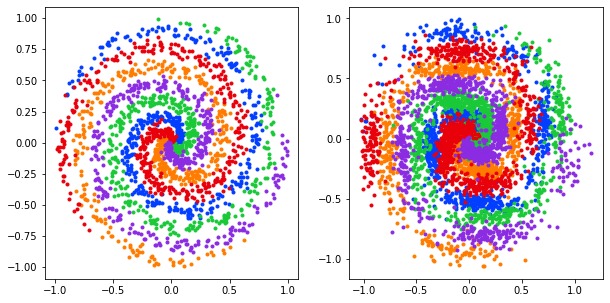

In [13]:
n_labels = 5
task_id = f"Spiral{n_labels}"
X1, y1 = generate_spirals(2000, n_class=n_labels)
X1_test, y1_test = generate_spirals(5000, n_class=n_labels)

rf_kwargs = {"n_estimators": 100, "verbose": 0}
kdg_spiral = kdf(kwargs=rf_kwargs)  # could also use KDN
kdg_spiral.fit(X1, y1, task_id, **rf_kwargs)

acc = np.mean(kdg_spiral.predict(X1_test, task_id) == y1_test)

posteriors = get_posteriors(kdg_spiral, task_id)

Xgen, ygen = kdg_spiral.generate_data(5000, task_id)
print(f"{task_id} accuracy: {acc}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plot_2dsim(X1, y1, palette="bright", ax=ax1)
plot_2dsim(Xgen, ygen, palette="bright", ax=ax2)

We can see that KDG learns the spiral well and with a high degree of accuracy (though the posterior is somewhat boxy). Now that we have confirmed KDG works well, we can begin testing transfer.

## Visualize posteriors (estimated runtime: 10 minutes)

The optimal transfer scenario is the **label flip** experiment, where a two-label data distribution is split in half and the labels of one half are transposed (from 0/1 to 1/0). This means that the probability distributions are fundamentally identical, and so polytopes learned from one distribution should be able to divide the other distribution with a high degree of accuracy. We will perform the label-flip below on a 2-class spiral.

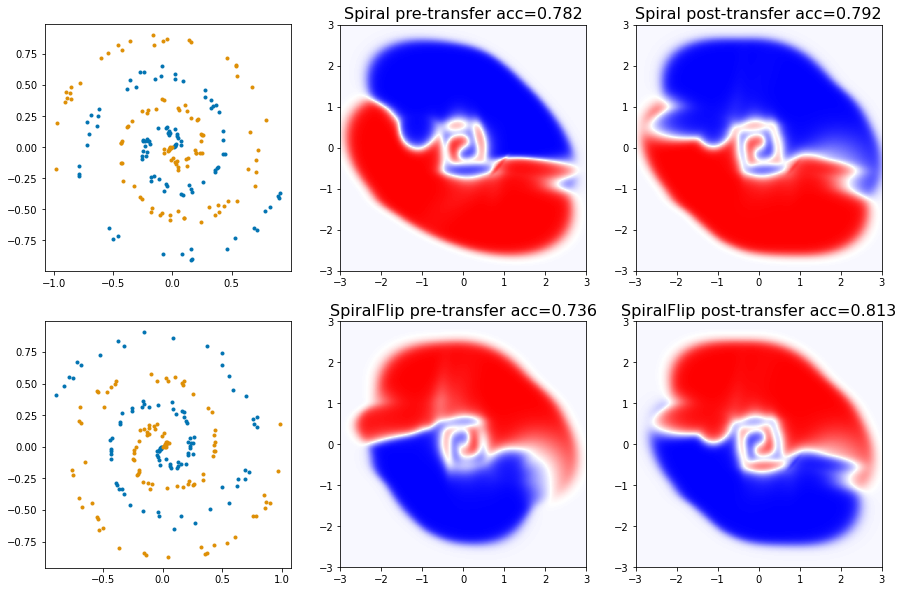

In [21]:
n_train = 200
n_test = 1000

X, y = generate_spirals(n_train * 2, n_class=2)
X_test, y_test = generate_spirals(n_test, n_class=2)

rf_kwargs = {"n_estimators": 100, "verbose": 0}
kdg_spiral = kdf(kwargs=rf_kwargs)  # could also use KDN

force_flip(X, y, X_test, y_test, "Spiral", kdg_spiral)

Note the significant improvement even with 200 samples per distribution. Now that we have proved transfer works in theory, we can experiment with other distributions. Here, we will attempt a transfer between 2-class spiral and ellipse, but you can use whatever distribution you like.


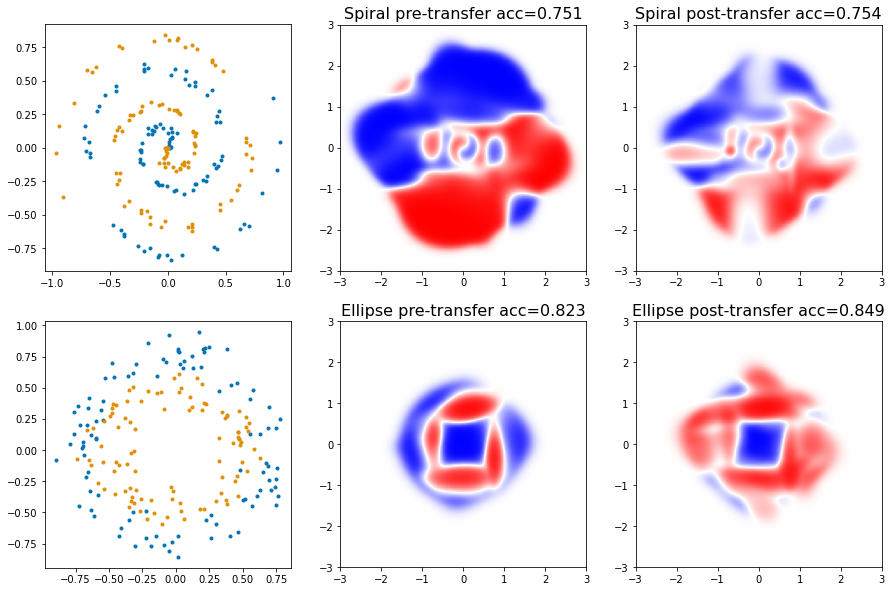

In [24]:
X1, y1 = generate_spirals(n_train, n_class=2)
X1_test, y1_test = generate_spirals(n_test, n_class=2)

X2, y2 = generate_ellipse(n_train, width=(0.75, 0.5))
X2_test, y2_test = generate_ellipse(n_test, width=(0.75, 0.5))

kdf_multitask = kdf(kwargs=rf_kwargs)  # could also use KDN

transfer_posteriors(
    X1,
    y1,
    X1_test,
    y1_test,
    X2,
    y2,
    X2_test,
    y2_test,
    "Spiral",
    "Ellipse",
    kdf_multitask,
)

Transfer is weaker in this instance, but does occur, particularly in the Spiral > Ellipse direction (transfer from Ellipse to Spiral is inconsistent across repeated trials). Therefore we can see that similar distributions are not required for transfer to occur. We will explore this more rigorously in the next section.

## Transfer Efficiency (estimated runtime: 1 hour)

Finally, to explore posterior transfer more completely, we would like to visualize the transfer efficiency as sample sizes change. We will create a figure modeled off of the one in [Vogelstein et al (2020)](https://https://arxiv.org/abs/2004.12908), which feeds two tasks in sequence into a learner and plots the generalization error for Task 1, the generalization error for Task 2, and the mean forward and backwards transfer efficiency.

Due to the way the KDG transfer algorithm is constructed, forward and backward transfer are computationally identical, so the only anticipated differences between forward and backward transfer are those that result from different sample sizes and the innate properties of the data distributions.

In [27]:
# define hyperparameters:
fit_kwargs = {"n_estimators": 500, "verbose": 0}
kdg_experiment = kdf(kwargs=fit_kwargs)
mc_rep = 20
n_t1 = np.arange(50, 751, step=50).astype(int)
n_t2 = np.arange(50, 751, step=50).astype(int)
n_test = 1000

# choose save path
save_path = "kdg_demo.npz"

# run the experiment on the selected data functions
mean_error, std_error, mean_te, std_te = run(
    kdg_experiment,
    mc_rep,
    n_t1,
    n_t2,
    n_test=n_test,
    task1_id="Spiral3",
    task2_id="Spiral5",
    gen_1=generate_spirals,
    gen_kwargs1={"n_class": 3},
    gen_kwargs2={"n_class": 5},
)

# Saving is optional.
# However, due to the runtime of an experiment it is highly recommended.
np.savez(save_path, task1=n_t1, task2=n_t2, mean_error=mean_error, mean_te=mean_te)

starting to compute 50 Spiral3
starting to compute 100 Spiral3
starting to compute 150 Spiral3
starting to compute 200 Spiral3
starting to compute 250 Spiral3
starting to compute 300 Spiral3
starting to compute 350 Spiral3
starting to compute 400 Spiral3
starting to compute 450 Spiral3
starting to compute 500 Spiral3
starting to compute 550 Spiral3
starting to compute 600 Spiral3
starting to compute 650 Spiral3
starting to compute 700 Spiral3
starting to compute 750 Spiral3
starting to compute 50 Spiral5
starting to compute 100 Spiral5
starting to compute 150 Spiral5
starting to compute 200 Spiral5
starting to compute 250 Spiral5
starting to compute 300 Spiral5
starting to compute 350 Spiral5
starting to compute 400 Spiral5
starting to compute 450 Spiral5
starting to compute 500 Spiral5
starting to compute 550 Spiral5
starting to compute 600 Spiral5
starting to compute 650 Spiral5
starting to compute 700 Spiral5
starting to compute 750 Spiral5


Finally, we visualize our results.

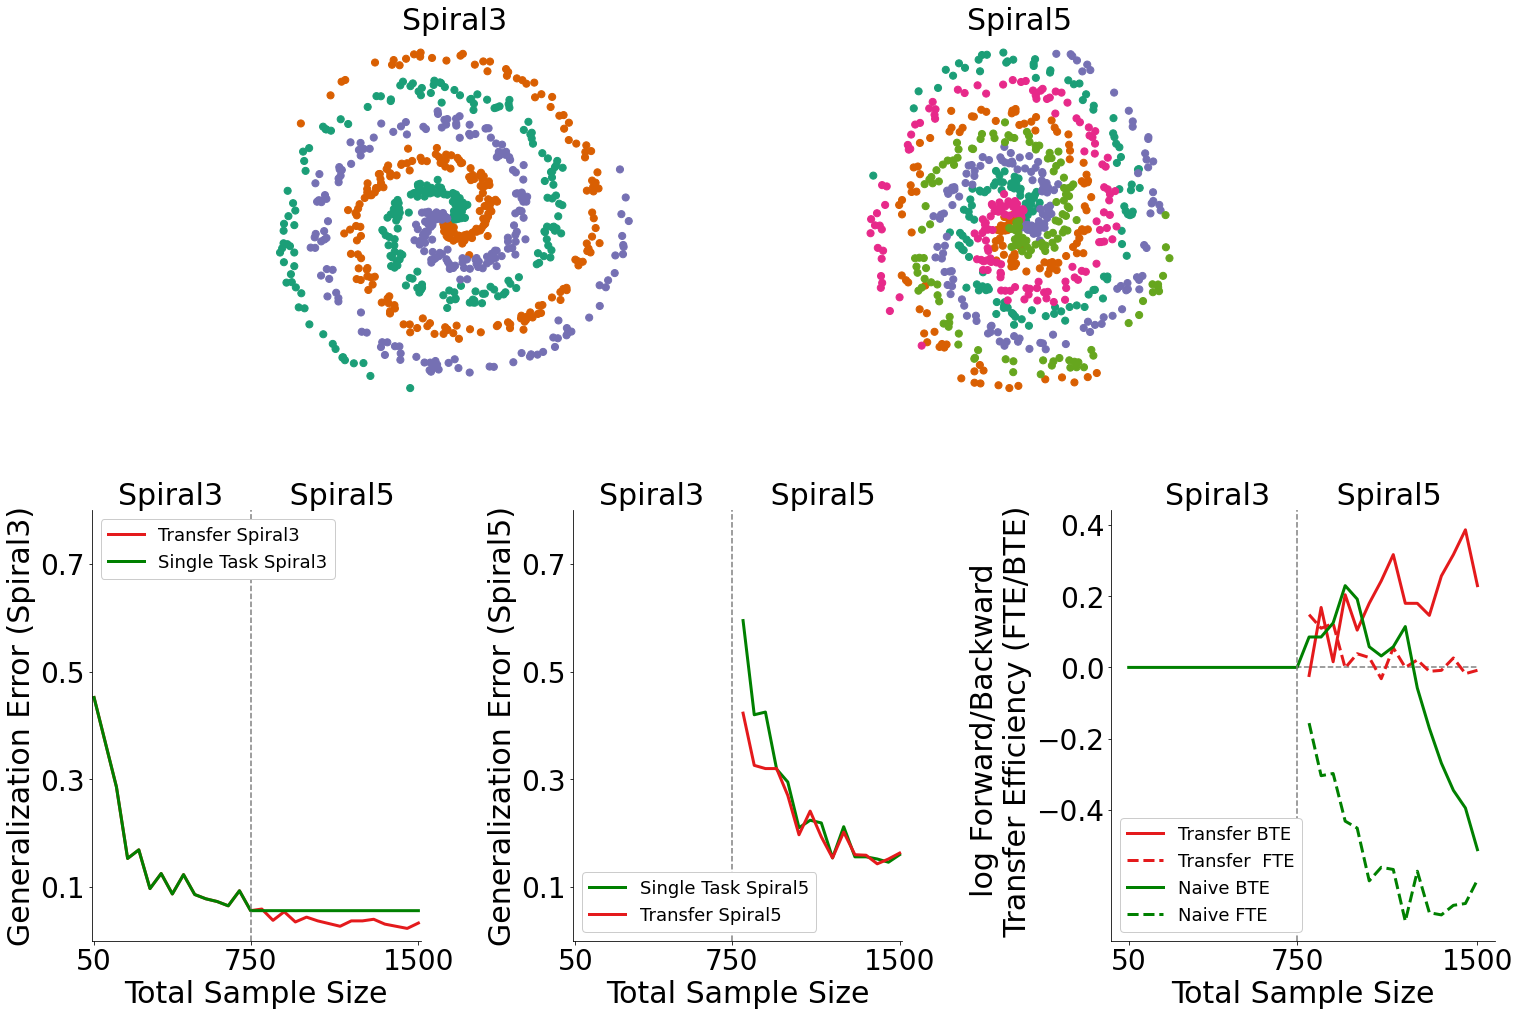

In [28]:
with np.load(save_path) as data:
    n_t1 = data["task1"]
    n_t2 = data["task2"]
    mean_error = data["mean_error"]
    mean_te = data["mean_te"]

n_data = max(np.max(n_t1), np.max(n_t2))

s3, s3_labels = generate_spirals(n_data, n_class=3)
s5, s5_labels = generate_spirals(n_data, n_class=5)

plot_error_and_eff(
    n_t1, n_t2, mean_error, mean_te, "Spiral3", "Spiral5", s3, s3_labels, s5, s5_labels
)